# Protein G dbfold test

In [2]:
import dbfold
from dbfold.dbfold import Protein as Protein
import dbfold.analyze_structures as analyze_structures
import dbfold.load_data as load_data
import dbfold.compute_PMF as compute_PMF
import dbfold.folding_rates as folding_rates
import dbfold.kinetic_model as kinetic_model
import dbfold.nonnative_states as nonnative_states
import matplotlib.pyplot as plt

First thing to do is visualize native substructures and also count total number of contacts. This is useful so that we can properly set up umbrella biasing in the energy minimizaiton simulations. Make sure to set the d_cutoff and min_seq_separation values to whatever you plan to use in the simulation!


In [3]:
unequilibrated_proteinG = Protein('protein G','1igd_data/1iGD.pdb')
print('This protein has {} contacts'.format(unequilibrated_proteinG.count_contacts(d_cutoff=6, min_seq_separation=8)))


hi
This protein has 36 contacts


# Running simulations and extracting data

The next step is to run minimization simulations, to equilibrate the protein in the potential. This can be done with the MCPU Monte-Carlos package, which is included as part of dbfold--detailed instructions are available in the MCPU Readme. Upon obtaining a minimized PDB structure, we count its contacts (for use in setting up umbrella biasing) and identify substructures. It may be worth experimenting to find parameters that produce sensible substructures for a given protein. We will both visualize the substructures on a contact map, and also produce a .pml file, which contains a series of commands to visualize these substructures directly on the equlibrated structure in PYMOL. This .pml file should be be opened along with the equilibrated .pdb in PYMOL.
We also save the substructure as a file 1igd_data/Substructures.dat

We note that the d_cutoff value used to generate substructures need not be the same as the one used to define contacts in the umbrella simulations, and likewise for min_seq_separation. In general, there may be two definitions of contacts: one that is used duruing simulation to perform umbrella biasing, and one that is used to produce substructures during analysis.

Finally we set the value of f to 1.7 as in the paper


hi
This protein has 42 contacts
The folded state is abcd


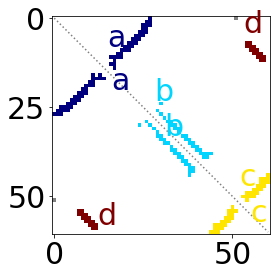

In [4]:
proteinG = Protein('protein G','1igd_data/1igd_0.200_20_Emin.pdb')
print('This protein has {} contacts'.format(proteinG.count_contacts(d_cutoff=6, min_seq_separation=8)))

proteinG.generate_subs(d_cutoff=6.5, min_seq_separation=3, contact_sep_thresh=7, min_clustersize=5, savepath = '1igd_data/Substructures.dat')
print('The folded state is {}'.format(proteinG.folded_state))
analyze_structures.create_substructure_PML(proteinG.native_structure, ['a','b','c','d'], 6.5, 7, 5, substructures = proteinG.substructures)

proteinG.set_f(1.7)

Next, we run equilibrium and unfolding simulations. As above, details for how to run these simulations in MCPU are available in the README.
We then extract data from these simulations for further analysis using the following steps:

   1. We run the script read_log_files.py to extract energies, number of native contacts, RMSD, and other variables of interest from the log file for each MC step at which these values were printed. It is only necessary that this be done for equilibrium simulations. The output is saved in a .dat file (for example, 1igd_data/Equilibrium_log_data.dat).

   2. We run get_snapshot_configs.py to obtain substructure scores from PDB files, which are necessary to assign each PDB snapshot to a topological configuration. This script can either generate the substructures de novo, which requires that we input the parameters to create the substructures used above, or it can be given a file Substructures.dat, which can be produced when generating substructures above if savepath is set to something other than None (the default value). The output is saved in a .dat file (for example, 1igd_data/Equilibrium_scores.dat and 1igd_data/Unfolding_scores.dat). This step should be run for both equilibrium and unfolding simulations.


IMPORTANT: The dbfold analysis package requires that the MCPU parameters MC_PRINT_STEPS and 
MC_PDB_PRINT_STEPS, which are set in the cfg files, have the same value. This ensures that the MC steps printed in the log files correspond to those for which PDB files are produced.

This algorithm can also be used with alternative simulation packages, including MD software, but the above scripts must be adapted to work with the PDB naming conventions and log file format for whichever program is used.



# Equilibrium properties

Let's load the test data for protein G. First, indicate the directory where the equilibrium data is stored, which in our case is 1igd_data. By default, this assumes the log data filename is Equilibrium_log_data.dat and the scores filename is Equilibrium_scores.dat, but these can be changed via the optional arguments log_data_filename and score_filename, respectively

In [3]:
proteinG.set_eq_path('1igd_data' )

Added equilibrium log datapath 1igd_data/Equilibrium_log_data.dat and scorepath 1igd_data/Equilibrium_scores.dat


We note that this file contains the data for the last 300 milion MC steps of a simulation that was run for a total of 1.2 billon MC steps.
Now, we assess convergence for the equilibrium simulations. To do this, we plot the simulation energy as a function of MC step, averaged over a sliding window of 50 million MC steps. We will do this at a number of temperatures, T = 0.8, 0.9, and 0.975

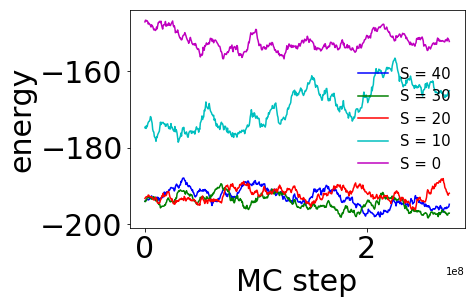

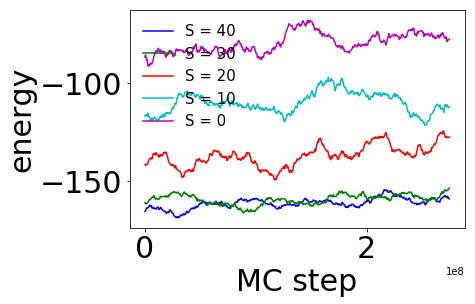

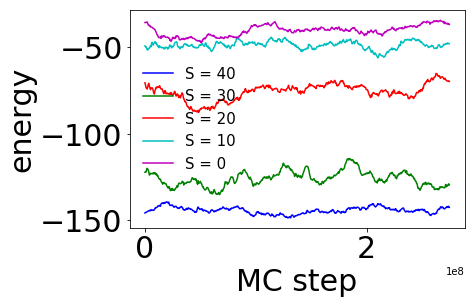

In [4]:
#fig, ax = plt.subplots(1,3)
#plt.subplots_adjust(wspace = 3)
compute_PMF.plotTrajectoryTimecourses(proteinG.log_datapath, 'energy', 
                          ['0.800_40.', '0.800_30.', '0.800_20.', '0.800_10.', '0.800_0.'], 
                          colors = ['b','g','r','c','m'], 
                          labels = ['S = 40', 'S = 30','S = 20','S = 10','S = 0'], sliding_windowlen = 50, 
                                     legend_fontsize = 15)

compute_PMF.plotTrajectoryTimecourses(proteinG.log_datapath, 'energy', 
                          ['0.900_40.', '0.900_30.', '0.900_20.', '0.900_10.', '0.900_0.'], 
                          colors = ['b','g','r','c','m'], 
                          labels = ['S = 40', 'S = 30','S = 20','S = 10','S = 0'], sliding_windowlen = 50, 
                                     legend_fontsize = 15)

compute_PMF.plotTrajectoryTimecourses(proteinG.log_datapath, 'energy', 
                          ['0.975_40.', '0.975_30.', '0.975_20.', '0.975_10.', '0.975_0.'], 
                          colors = ['b','g','r','c','m'], 
                          labels = ['S = 40', 'S = 30','S = 20','S = 10','S = 0'], sliding_windowlen = 50, 
                                     legend_fontsize = 15)


From the above plots, it appears that beyond 150 million MC steps, these energies generally cease changing substantially. Thus we will compute all equilibium thermodynamic properties starting with this timestep.
We do this below. As in the paper, we define a substructure using a value of f=1.7, where f is the maximum value of the average distance between residues assigned to a substructure within a snapshot
dived by that same average distance in the native file such that a substructure is considered formed

The k_bias value should always correspond to the one used in umbrella simulations. This assumes biasing was performed along native contacts


In [114]:
proteinG.obtain_PMFs(eq_step=150000000, k_bias = 0.02)

PMFs already exist! Loading now...
PMFs successfully loaded


We will now plot a melting curve that shows fraction of native contacts (using the contacts definition in the umbrella simulations) as a function of temperature. There are two ways of doing this:

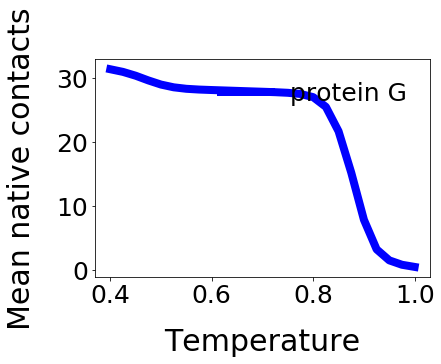

In [6]:
proteinG.plot_melting_curve()

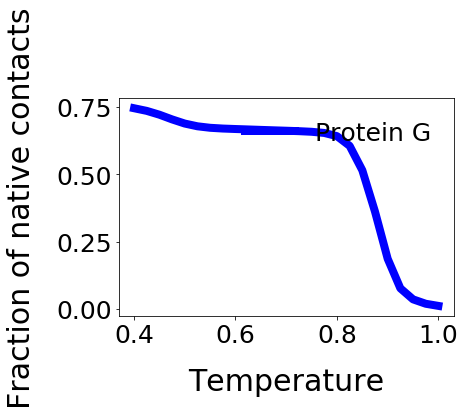

In [6]:
compute_PMF.plot_natives_vs_temp(['1igd_data'], ['Protein G'], norm = 'Fraction', d_cutoff =6, 
                     Native_structures = ['1igd_data/1igd_0.200_20_Emin.pdb'])

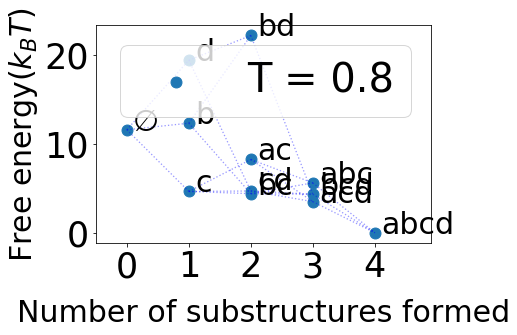

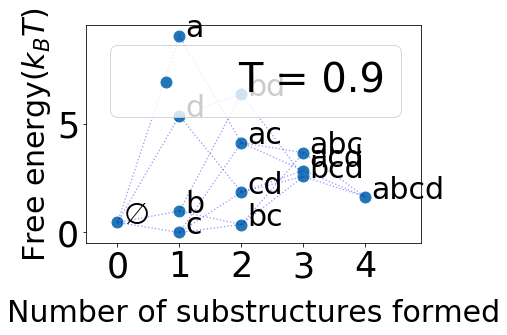

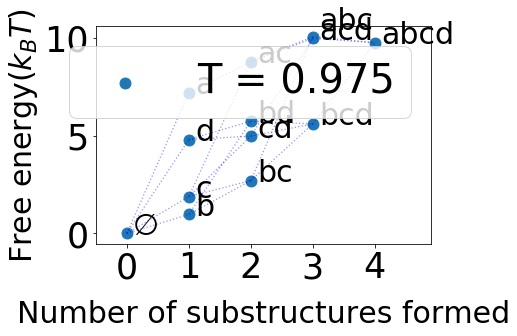

In [134]:
importlib.reload(dbfold.compute_PMF)


compute_PMF.plot_substructure_PMF('1igd_data/PMFs.dat', [0.8])
compute_PMF.plot_substructure_PMF('1igd_data/PMFs.dat', [0.9])
compute_PMF.plot_substructure_PMF('1igd_data/PMFs.dat', [0.975])

# Nonnative contacts

To produce nonnative contact maps, we must run the script get_snapshot_contact_maps.py, which extracts contact maps (including both native and nonnative contacts--the former can be filtered out in subsequent analyses) for snapshots of interest (for instnace, those assigned to a specific subset of topological configuration at a specific temperature range). These contact maps are saved in a .dat file (e.g. 1igd_data/Nonnative_maps(b)c.dat), and they are analyzed below.

For the case of protein G consider the nonnative contacts among all snapshots assigned to topological configurations c or bc at physiologically reasonable temperatures. We can visualize the average nonnative contact map among such snapshots by accessing the data stored in 1igd_data/Nonnative_maps_(b)c.dat

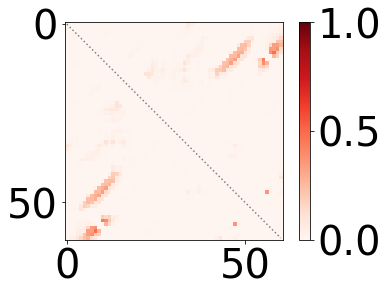

In [75]:
nonnative_states.visualize_nonnatives('1igd_data/Nonnative_maps_(b)c.dat', proteinG.native_structure, d_cutoff = 6.5, min_seq_separation = 3 ,filter_distance = 0,cmap = 'Reds')

We can also cluster these snapshots into structurally distinct, recurrent nonnative states.
You can experiment with the thresh, which is the maximum allowed Hamming distance between the nonnative contact maps for two snapshots such that they are clustered together

Mean number of nonnative contacts is 21.011879049676025


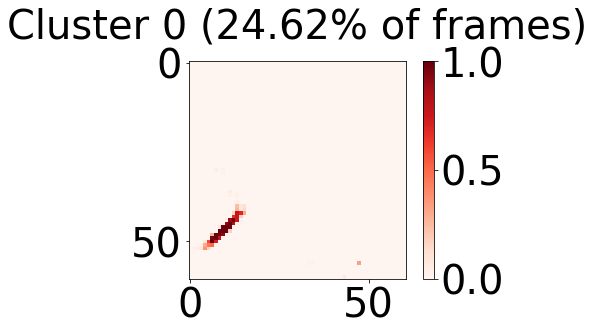

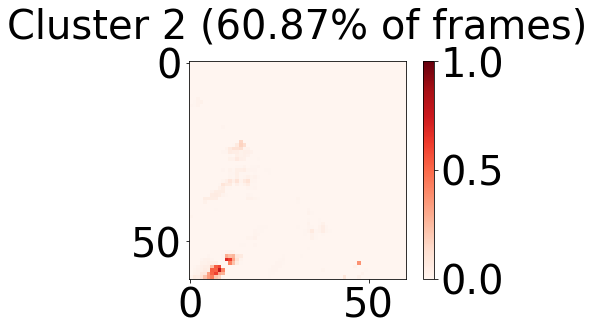

In [77]:
clusters, percentages, mean_maps = nonnative_states.cluster_nonnatives('1igd_data/Nonnative_maps_(b)c.dat', proteinG.native_structure, d_cutoff = 6.5, 
                                                                       filter_distance = 0,min_seq_separation = 3 ,cmap = 'Reds', thresh = 10)

# Folding rate calculation

Let us now proceed with calculating folding rates. Note that this expects files from unfolding simulations to be titled ProteinName_temperature_TrajectoryNumber.MCStep, for instance 1igd_0.500_0.50000000

In [9]:
proteinG.set_unfolding_path('1igd_data')
proteinG.runHMM(s=0,m=0.1, starting_state = 'folded')

The following parameters will be used to run HMM: 
 f = 1.7 
 s = 0 
 m = 0.1 
 starting_state = abcd 
Loading scores...
Training HMM...
Computing kinetic distances...
From this resulting distance map, you may choose to cluster by choosing an adjancy threshold T_A that results in a significant separation of exchange timescales


We will use a kinetic threshold of 100 (note this is in units of millions of MC steps, so 100 means 100 million)

In [13]:
proteinG.form_clusters(T_A = 100)

A value of T_A = 100 will be used to form clusters
Doing loop clustering...
We have obtained the following clusters: 
 {0: ['abcd', 'acd'], 1: ['bcd', 'cd'], 2: ['abd', 'ad'], 3: ['abc', 'ac'], 4: ['bd', 'd'], 5: ['bc', 'c'], 6: ['ab', 'a'], 7: ['b', '∅']} 
 Please make sure that unfolding rates fit well to Arrhenius equation before proceeding 


Let's see how the resulting unfolding rates fit to the Arrhenius equation. Importantly,the Arrhenius temperatures are should be multipled by the Boltzmann constant (i.e. in units of energy) prior to inputting to this function

In [22]:
%matplotlib tk
activation_energies, prefactors, mean_transition_rates, Ns=Arrhenius_fit([ 0.9, 0.925, 0.95, 0.975, 1], [(0,3), (3,5), (5,7)],
                                                                         proteinG.temp_unfolding_info['combined_trajs'],
                                                                         proteinG.temp_unfolding_info['PDB files'], 
                                                                         'Pathway 1',
                                                                         legend_loc='lower left', min_trans = 3, fontsize = 20,
                                                                         labelsize = 20, legend_fontsize = 20, show_rsquared = False,
                                                                         colors = ['firebrick', 'mediumblue', 'gold'], temp_norm = 0.882, 
                                                                         labels = ['a(b)cd -> a(b)c', 'a(b)c -> (b)c', '(b)c -> (b)'])

activation_energies, prefactors, mean_transition_rates, Ns=Arrhenius_fit([  0.9, 0.925, 0.95, 0.975, 1], [(0,1), (1,5), (5,7)],
                                                                         proteinG.temp_unfolding_info['combined_trajs'], 
                                                                         proteinG.temp_unfolding_info['PDB files'], 
                                                                         'Pathway 2', 
                                                                         legend_loc='lower left', min_trans = 3, fontsize = 20, 
                                                                         labelsize = 20,  legend_fontsize = 20,show_rsquared = False,
                                                                         colors = ['cornflowerblue', 'purple', 'gold'], temp_norm = 0.882,
                                                                         labels = ['a(b)cd -> (b)cd', '(b)cd -> (b)c', '(b)c -> (b)'])

Computing temperature 0.9


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:393: RuntimeWarning: invalid value encountered in true_divide


Computing temperature 0.925
Computing temperature 0.95
Computing temperature 0.975
Computing temperature 1
0.9980311084118759
0.9763868338574417
0.9759502334367826
Computing temperature 0.9
Computing temperature 0.925
Computing temperature 0.95
Computing temperature 0.975
Computing temperature 1
0.9898933528051476
0.890180210595747
0.9759502334367826


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


If we agree to this Arrhenius fit, then we will go ahead and compute folding rates and obtain an error distribution by bootstrapping. Note that if you set N_trials=1000 as below, this will take a few minutes to run.


In [38]:
proteinG.obtain_folding_rates(Arrhenius_temps=[ 0.9, 0.925, 0.95, 0.975, 1], unfolding_transitions_of_interest= [(0,3), (3,5), (5,7), (0,1), (1,5)], N_trials=1000, min_trans=3)

Computing temperature 0.9


/Users/amirbitran/Dropbox/CurrentStuff/Harvard/Shakhnovich Lab/dbfold/dbfold/folding_rates.py:485: RuntimeWarning: invalid value encountered in true_divide
  transmat=np.divide(counts, norm)


Computing temperature 0.925
Computing temperature 0.95
Computing temperature 0.975
Computing temperature 1
0.9898933528051476
0.9980311084118759
0.890180210595747
0.9763868338574417
0.9759502334367826
Running 1000 bootstrap trials to compute error on unfolding rates...
0 trials completed


/Users/amirbitran/Dropbox/CurrentStuff/Harvard/Shakhnovich Lab/dbfold/dbfold/folding_rates.py:694: RuntimeWarning: invalid value encountered in double_scalars
  rates[i,j]=(sum_lambdai*transmat[i,j])/(1-np.exp(-sum_lambdai*dt))
/Users/amirbitran/Dropbox/CurrentStuff/Harvard/Shakhnovich Lab/dbfold/dbfold/folding_rates.py:691: RuntimeWarning: divide by zero encountered in double_scalars
  sum_lambdai=1/dt*np.log(1/transmat[i,i])


100 trials completed
200 trials completed
300 trials completed
400 trials completed
500 trials completed
600 trials completed
700 trials completed
800 trials completed
900 trials completed
Bootstrap complete
Computing cluster free energies...
Inferring unknown folding rates from detailed balance...
Folding rate calculation complete!


/Users/amirbitran/Dropbox/CurrentStuff/Harvard/Shakhnovich Lab/dbfold/dbfold/folding_rates.py:433: RuntimeWarning: divide by zero encountered in log
  if -np.log(unfolding_rates[a,b,t]) < (G[t,b] - G[t,a]):  #barrier height is lower than free energy difference...typically this implies Arrhenius approximation is failing
/Users/amirbitran/Dropbox/CurrentStuff/Harvard/Shakhnovich Lab/dbfold/dbfold/folding_rates.py:435: RuntimeWarning: invalid value encountered in multiply
  folding_rates[b,a,:]= unfolding_rates[a,b,:] * np.exp(G[:,b] - G[:,a])  #detailed balance!
/Users/amirbitran/Dropbox/CurrentStuff/Harvard/Shakhnovich Lab/dbfold/dbfold/folding_rates.py:433: RuntimeWarning: invalid value encountered in double_scalars
  if -np.log(unfolding_rates[a,b,t]) < (G[t,b] - G[t,a]):  #barrier height is lower than free energy difference...typically this implies Arrhenius approximation is failing
/Users/amirbitran/Dropbox/CurrentStuff/Harvard/Shakhnovich Lab/dbfold/dbfold/folding_rates.py:435: Run

Let us now plot some of these predicted folding rates

In [50]:
fontsize = 20
labelsize = 20
TM = 0.879

folding_rates.plot_folding_rates('1igd_data/Folding_info.dat', '$\emptyset/b$ -> (b)c', [(7,5)], fontsize = fontsize, labelsize = labelsize,              
                                                               legend_fontsize = fontsize, colors = ['gold'], temp_norm = TM, legend = False)

plt.xlim((0.82, 1.14))
plt.ylim((5*10**(-11), 10**(-7)))

folding_rates.plot_folding_rates('1igd_data/Folding_info.dat', '(b)c -> a(b)c', [(5,3)], fontsize = fontsize, labelsize = labelsize,              
                                                               legend_fontsize = fontsize, colors = ['mediumblue'], temp_norm = TM, legend = False)
plt.xlim((0.82, 1.14))
plt.ylim((5*10**(-11), 10**(-7)))


folding_rates.plot_folding_rates('1igd_data/Folding_info.dat', '(b)c -> (b)cd', [(5,1)], fontsize = fontsize, labelsize = labelsize,              
                                                               legend_fontsize = fontsize, colors = ['purple'], temp_norm = TM, legend = False)
plt.xlim((0.82, 1.14))
plt.ylim((5*10**(-11), 10**(-7)))


folding_rates.plot_folding_rates('1igd_data/Folding_info.dat', '(b)cd -> a(b)cd', [(1,0)], fontsize = fontsize, labelsize = labelsize,              
                                                               legend_fontsize = fontsize, colors = ['cornflowerblue'], temp_norm = TM, legend = False)

plt.xlim((0.82, 1.14))
plt.ylim((5*10**(-11), 10**(-7)))


(4.9999999999999995e-11, 1e-07)

# Kinetic model

In general, the kinetic model class is designed for modelling co-translational folding, but it can also be used to solve master equation for a single protein (at its fully synthesized length). We will do that for protein G. 

In [112]:
km = kinetic_model.Kinetic_model('1igd', [61], folding_rate_paths = ['1igd_data/Folding_info.dat'], omit_transitions = [(3,0)])
#km.rates[0][3,0,:] = 0  #delete connections between 3 and 0 (abc and abcd) 
#since our method does not accurately predict this folding rate
#km.rates[0][0,3,:] = 0
km.diagonalize()




Length 61: Deleting cluster ['abd', 'ad']
Length 61: Deleting cluster ['bd', 'd']
Length 61: Deleting cluster ['ab', 'a']
	


We can now plot the solution to the master equation

Text(0.5, 0, 'Time (MC Steps)')

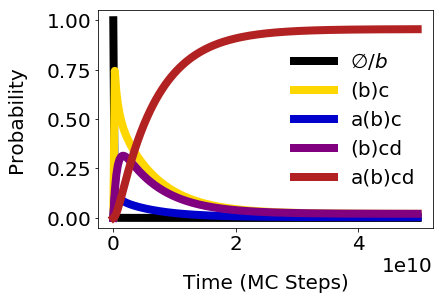

In [113]:
fig, ax = plt.subplots()
kinetic_model.plot_timecourse(km, 0.8, [5*10**(10)], [[4,3,2,1,0]], starting_state = -1, final_time = None, colors= ['k','gold', 'mediumblue', 'purple', 'firebrick'], 
                 linewidth = 8,colorchange = (None, None, None), scientific = True, ylim = (), ax = ax,ntimes = 200,fontsize=20, 
                 labelsize = 20, timenorm = 1, ylabel = True, xlabel= True)

ax.legend(labels = ['$\emptyset / b$', '(b)c', 'a(b)c', '(b)cd', 'a(b)cd'], fontsize = fontsize)
ax.xaxis.get_offset_text().set_fontsize(20)

ax.set_xlabel('Time (MC Steps)', fontsize = fontsize)



In [132]:
import importlib
importlib.reload(dbfold.utils)
importlib.reload(dbfold.folding_rates)
importlib.reload(dbfold.compute_PMF)
importlib.reload(dbfold.folding_rates)
importlib.reload(dbfold.analyze_structures)
importlib.reload(dbfold.nonnative_states)
importlib.reload(dbfold.kinetic_model)






<module 'dbfold.kinetic_model' from '/Users/amirbitran/Dropbox/CurrentStuff/Harvard/Shakhnovich Lab/dbfold/dbfold/kinetic_model.py'>